In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# Differentiating through randomness

## Fixed noise distribution

In the previous notebook (01-automatic-differentiation) we covered the basics of automatic differentiation (AD). However, we left a particular topic untouched. How can we compute the derivative of stochastic programs, and what does that mean, exactly?

Consider the following program with parameter $\theta$

$$

\begin{align}
    z &\sim \mathcal N(1, 2) \\
    y &= \theta^2(z+4)
\end{align}

$$

where $\mathcal N$ is the Normal distribution. This can be coded as:

In [93]:
def f(theta):
    z = np.random.normal(1, 2)
    return theta**2 * (z + 4)

So, what does it mean to compute

$$
\frac{\partial f(\theta)}{\partial \theta} =  \; ?
$$

If we think about the definition of derivative,

$$
\frac{\partial X(\theta)}{\partial \theta} =  \lim_{\epsilon \to 0} \frac{X(\theta+\epsilon) - X(\theta)}{\epsilon}.
$$

we can observe that this derivative is not well defined since the difference $X(\theta+\epsilon) - X(\theta)$ will take random values and it is not clear how to treat this limit.

However, in most cases, we are actually interested in the derivative of an **average** model realization, not just the derivative of a single run. In other words, we want to take gradients of the form

$$
\mathbb E_{p(z)} [f_\theta(z)],
$$

where $p$ is a probability density and $f$ is a (deterministic) simulator with structural parameters $\theta$. Taking the derivative we have

$$
\begin{align}
    \nabla_\theta \mathbb E_{p(z)}\;\left[f_\theta(z)\right] &= \nabla_\theta\left[\int_z p(z) f_\theta(z)\mathrm{d}z\right]\\
                                                             &=  \int_z p(z)\left[\nabla_\theta f_\theta(z)\right]\mathrm{d} z \\
                                                             &= \mathbb E_{p(z)}[\nabla_\theta f_\theta(z)]
\end{align}
$$

so that the gradient of the expectation is the expectation of the gradient.

In our considered example, this translates to

$$
\mathbb E_{z \sim \mathcal N(1, 2)}\;\left[\theta^2(z+4)\right]
$$

now we can take the derivative

$$
\nabla_\theta \mathbb E_{z \sim \mathcal N(1, 2)}\;\left[\theta(z+4)\right] = \mathbb E_{z\sim \mathcal N(1,2)} \left[\nabla_\theta \theta^2(z+4)\right] = 10\, \theta
$$

Let's check this result numerically and see the troubles we find.

In [109]:
theta = 2.0
epsilons = [1.0, 0.5, 0.1]
n_samples = 10_000
samples_per_epsilon = {epsilon: [] for epsilon in epsilons}
for epsilon in epsilons:
    for i in range(n_samples):
        f_deriv = (f(theta + epsilon) - f(theta)) / (epsilon)
        samples_per_epsilon[epsilon].append(f_deriv)

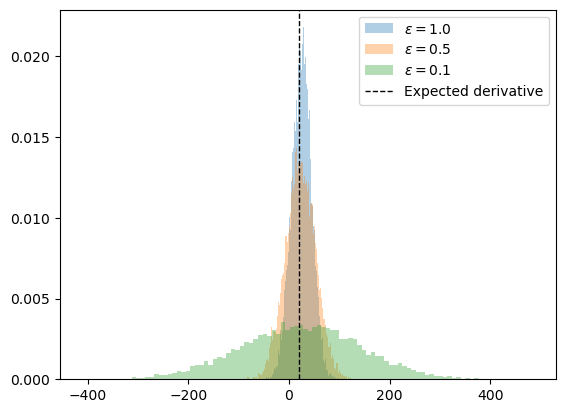

In [110]:
fig, ax = plt.subplots()
for i, (epsilon, samples) in enumerate(samples_per_epsilon.items()):
    ax.hist(samples, bins=100, alpha=0.35, label=f'$\epsilon={epsilon}$', density=True, color = f"C{i}")
ax.axvline(theta*10, color='black', linestyle='dashed', linewidth=1, label = "Expected derivative")
ax.legend()

What is going on? The smaller $\epsilon$ is, the variance of our estimator is going $\to \infty$! 

This is caused by the fact that the two function calls $X(p)$ and $X(p+\epsilon)$ are uncorrelated (they have a different random seed) and so even calling the program for very similar values of $p$ can cause large differences. 

Nonetheless, the finite differences method gives an unbiased estimator in this case.

This issue is not present in automatic differentiation engines, since they only require one evaluation of the model:

In [111]:
def f_torch(theta):
    z = torch.normal(1.0, 2.0, (1,))[0]
    return theta**2 * (z + 4)

n_samples = 10_000
samples_autograd = []
for i in range(n_samples):
    theta = torch.tensor(2.0, requires_grad=True)
    f_torch(theta).backward()
    samples_autograd.append(theta.grad)

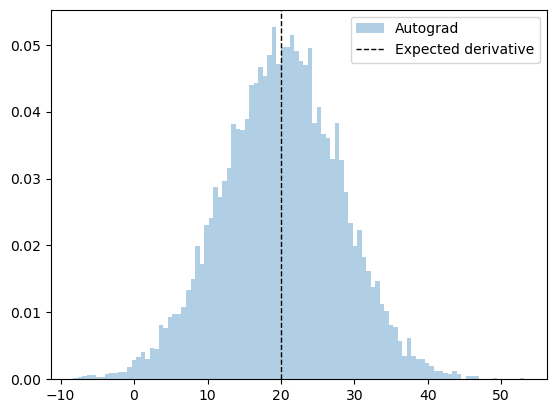

In [116]:
fig, ax = plt.subplots()
ax.hist(samples_autograd, bins=100, alpha=0.35, label='Autograd', density=True, color = "C0");
ax.axvline(20, color='black', linestyle='dashed', linewidth=1, label = "Expected derivative")
ax.legend()

As we can see, the variance is much lower than the finite difference case.

## Parameterizable noise

In the example above, we made the assumption that the randomness of our model $p(z)$ did not depend on the structural parameters $\theta$ that we want to differentiate by.

However, in most agent-based models this assumption does not hold. Consider, for instance, the case of an SIR model where agents become infected with some probability $p$. This probability may depend on structural parameters such as $R_0$ or social distancing measures that we want to calibrate.

So now we have

$$
\nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)],
$$

expanding the same way as before we find

$$
\begin{align}
    \nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)] &= \nabla_\theta \left[ \int_z p_\theta(z) f_\theta(z) \mathrm{d}z\right]\\
                                                       &= \int_z \nabla_\theta\left[p_\theta(z) f_\theta(z)\right] \mathrm{d}z\\
                                                       &= \int_z f_\theta(z)\nabla_\theta p_\theta(z)\mathrm{d} z + \int_z p_\theta(z) \nabla_\theta f_\theta(z)\mathrm{d}z\\
                                                       &= \int_z f_\theta(z) \nabla_\theta p_\theta(z) \mathrm{d} z + \mathbb E_{p_\theta(z)} \left[\nabla_\theta f_\theta(z)\right]
\end{align}
$$

notice that now we have an additional term, $\int_z f_\theta(z) \nabla_\theta p_\theta(z) \mathrm{d} z$, that prevents us from commuting the gradient and the expectation. So, in general, **the gradient of the expectation is not the expectation of the gradient**.


### The reparameterization trick

To circumvent this, we introduce the [reparameterization trick](https://arxiv.org/pdf/1312.6114.pdf). Continuous distributions have a property that allows an indirect way of sampling from them. One is direct sampling

$$ x \sim p_\theta(x) $$

and indirectly,

$$ \epsilon \sim p(\epsilon), x = g(\epsilon, \theta) $$

where $g$ is a deterministic path that maps parameter-free noise ($\epsilon$) to $x$. For instance, to sample from a Normal distribution $\mathcal N(\mu, \sigma^2)$, we can do

$$ \epsilon \sim \mathcal N(0, 1), \hspace{0.5cm} x = g(\epsilon, \theta) = \mu + \sigma \epsilon. $$

What have we accomplished with this? We have untangled the "random" part of the distribution from the part that depends on the parameters.